# 베이스라인

In [1]:
import os
import json
import glob
from tqdm import tqdm
from collections import defaultdict
import shutil

print("--- [Phase 1] 데이터 통합 및 정제 시작 ---")

# 경로 설정
base_dir = r"C:\Users\daboi\Desktop\ai05-level1-project"
train_img_dir = os.path.join(base_dir, "train_images")
train_ann_dir = os.path.join(base_dir, "train_annotations")

# 모든 JSON 파일 검색
json_files = glob.glob(os.path.join(train_ann_dir, "**", "*.json"), recursive=True)
print(f"총 {len(json_files)}개의 JSON 어노테이션 파일 검색")

# 데이터 통합 (1489개 이미지)
master_data = defaultdict(lambda: {
    'image_path': '', 
    'width': 0, 
    'height': 0, 
    'annotations': []
})

class_to_id = {} # YOLO 학습용 ID (0, 1, 2...)
current_id = 0
processing_errors = 0

for json_path in tqdm(json_files, desc="통합 중 (Phase 1)"):
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        img_info = data['images'][0]
        img_filename = img_info['file_name']

        if not master_data[img_filename]['image_path']:
            image_path = os.path.join(train_img_dir, img_filename)
            master_data[img_filename]['image_path'] = image_path
            master_data[img_filename]['width'] = img_info['width']
            master_data[img_filename]['height'] = img_info['height']

        category_map = {cat['id']: cat['name'] for cat in data['categories']}

        for ann in data['annotations']:
            bbox = ann['bbox'] # [x, y, w, h]
            ann_cat_id = ann['category_id']
            
            if ann_cat_id not in category_map:
                processing_errors += 1
                continue

            class_name = category_map[ann_cat_id]

            if class_name not in class_to_id:
                class_to_id[class_name] = current_id
                current_id += 1
                
            class_id = class_to_id[class_name]

            master_data[img_filename]['annotations'].append({
                'class_id': class_id,
                'class_name': class_name,
                'bbox': bbox
            })
    except Exception:
        continue

print(f"총 {len(master_data)}개의 이미지 데이터 통합 완료 (정제 전)")
print(f"총 {len(class_to_id)}개의 고유 클래스 발견")

# 오류 데이터 제거 (17개 파일)
print("\nEDA 기반 오류 파일 17개 제거 시작")
iou_error_files = [
    "K-003351-018147-020238_0_2_0_2_90_000_200.png", 
    "K-003483-027733-030308-036637_0_2_0_2_90_000_200.png",
    "K-003351-020238-031863_0_2_0_2_70_000_200.png", 
    "K-003351-029667-031863_0_2_0_2_70_000_200.png",
    "K-003483-019861-025367-029667_0_2_0_2_90_000_200.png", 
    "K-002483-003743-012081-019552_0_2_0_2_90_000_200.png",
    "K-003483-019861-020238-031885_0_2_0_2_70_000_200.png", 
    "K-003351-003832-029667_0_2_0_2_90_000_200.png",
    "K-001900-016548-019607-033009_0_2_0_2_70_000_200.png"
]
oob_error_files = [
    "K-003351-016262-018357_0_2_0_2_75_000_200.png",
    "K-003544-004543-012247-016551_0_2_0_2_70_000_200.png"
]
nexium_suspect_images = [
    'K-001900-010224-016551-031705_0_2_0_2_70_000_200.png', 
    'K-001900-010224-016551-031705_0_2_0_2_75_000_200.png',
    'K-001900-010224-016551-031705_0_2_0_2_90_000_200.png', 
    'K-001900-010224-016551-033009_0_2_0_2_70_000_200.png',
    'K-001900-010224-016551-033009_0_2_0_2_75_000_200.png', 
    'K-001900-010224-016551-033009_0_2_0_2_90_000_200.png'
]
files_to_delete = set(iou_error_files + oob_error_files + nexium_suspect_images)

deleted_count = 0
# 원본 master_data의 복사본을 순회 (순회 중 원본 삭제를 위해)
for filename in list(master_data.keys()):
    if filename in files_to_delete:
        del master_data[filename]
        deleted_count += 1

print(f"총 {deleted_count}개의 오류 파일을 master_data에서 삭제")
print(f"최종 정제된 master_data 개수: {len(master_data)}개 (1472개여야 함)")


# 최종 산출물 저장
# 정제된 1472개 데이터
clean_master_path = os.path.join(base_dir, "train_master_annotations_clean.json")
with open(clean_master_path, "w", encoding='utf-8') as f:
    json.dump(master_data, f, ensure_ascii=False, indent=4)

# 클래스 ID 맵
class_map_path = os.path.join(base_dir, "class_to_id.json")
with open(class_map_path, "w", encoding='utf-8') as f:
    json.dump(class_to_id, f, ensure_ascii=False, indent=4)

print(f"파일 저장 완료: {clean_master_path}")
print(f"파일 저장 완료: {class_map_path}")
print("--- [Phase 1] 완료 ---")

--- [Phase 1] 데이터 통합 및 정제 시작 ---
총 4526개의 JSON 어노테이션 파일 검색


통합 중 (Phase 1): 100%|██████████| 4526/4526 [00:26<00:00, 172.79it/s]


총 1489개의 이미지 데이터 통합 완료 (정제 전)
총 73개의 고유 클래스 발견

EDA 기반 오류 파일 17개 제거 시작
총 17개의 오류 파일을 master_data에서 삭제
최종 정제된 master_data 개수: 1472개 (1472개여야 함)
파일 저장 완료: C:\Users\daboi\Desktop\ai05-level1-project\train_master_annotations_clean.json
파일 저장 완료: C:\Users\daboi\Desktop\ai05-level1-project\class_to_id.json
--- [Phase 1] 완료 ---


- 학습률 설정 원칙SGD는 Adaptive 옵티마이저보다 높은 학습률로 시작하는 것이 일반적이다 (예: 0.01 또는 0.02)
- Adaptive 옵티마이저 (Adam, AdamW, Nadam, RMSprop)는 파라미터별로 학습률을 자동으로 조정하기 때문에 SGD의 1/10 수준인 0.001 이하의 낮은 초기 학습률을 사용해야 손실(Loss)이 폭발하는 것을 막고 안정적인 수렴을 유도할 수 있다

## SGD 
- Momentum 0.01 Baseline (가장 높은 LR)
- 현재 경사와 이전 이동 방향(관성)을 결합하여 가중치를 업데이트
- 일반화 성능이 우수하며 최적화가 안정적임

In [ ]:
import os
import json
import glob
from ultralytics import YOLO
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import time # 시간 측정을 위해 추가

# --- 폰트 설정 ---
if platform.system() == 'Windows':
    try:
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    except:
        rc('font', family='DejaVu Sans')
else:  
    rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False 
# --- 폰트 설정 끝 ---


# 경로 설정
base_dir = r"C:\Users\daboi\Desktop\ai05-level1-project"
combined_dataset_dir = os.path.join(base_dir, "CombinedDataset3")
yaml_path_combined = os.path.join(combined_dataset_dir, 'data_70_15_15_split.yaml')
exp_dir = os.path.join(base_dir, "Exp")
class_to_id_path = os.path.join(base_dir, "class_to_id.json")

# 파일 존재 여부 확인
if not os.path.exists(class_to_id_path):
    print(f"오류: class_to_id.json 파일을 찾을 수 없음")
    exit()
if not os.path.exists(yaml_path_combined):
    print(f"오류: data_70_15_15_split.yaml 파일을 찾을 수 없음")
    exit()

print(f"Combined 데이터셋 경로: {combined_dataset_dir}")
print(f"data.yaml 경로: {yaml_path_combined}")
print("="*50)

# Baseline 모델 학습
print("\n[YOLOv8n] '1단계: Baseline (Aug OFF, Epochs 70)' 학습 시작")
print("="*50)

model = YOLO('yolov8n.pt')

experiment_name = 'yolo_n_baseline_SGD_lr01_e70' # 실험 이름에 e70 추가

# --- 학습 시간 측정 시작 ---
start_time = time.time()

results = model.train(
    data=yaml_path_combined,
    epochs=70,    
    patience=10,
    imgsz=640,
    batch=16,
    device=0,
    project=exp_dir,
    name=experiment_name, 
    exist_ok=True,
    optimizer='SGD', 
    lr0=0.01, 
    augment=False,
    workers=0,
)

# --- 학습 시간 측정 종료 및 저장 ---
end_time = time.time()
total_time_seconds = end_time - start_time
print(f"\n총 학습 시간: {total_time_seconds:.2f}초")

time_data = {'total_training_time_seconds': total_time_seconds}
time_path = os.path.join(exp_dir, experiment_name, 'training_time.json')
try:
    with open(time_path, 'w') as f:
        json.dump(time_data, f)
    print(f"학습 시간 저장 완료: {time_path}")
except Exception as e:
    print(f"오류: 학습 시간 저장 실패 - {e}")
# --- 시간 저장 끝 ---


# 학습 완료 후 최종 mAP 확인
print("\n'Baseline (Aug OFF, Epochs 70)' 학습 완료")
print("\n최종 검증 수행 (시각화 포함)")
best_model_path = os.path.join(exp_dir, experiment_name, 'weights', 'best.pt')

if os.path.exists(best_model_path):
    print(f"'{best_model_path}' 에서 best.pt 모델을 로드")
    best_model = YOLO(best_model_path)
    
    val_results = best_model.val(
        data=yaml_path_combined,
        split='val',
        verbose=True,
        plots=True
    )
    
    print("\n" + "="*50)
    print(f"최종 검증 결과 ({experiment_name} - Best Model)")
    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP75: {val_results.box.map75:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")
    print("="*50)
    print(f"시각화 결과 '{os.path.join(exp_dir, experiment_name)}' 폴더에 저장")
else:
    print(f"오류: 최적 모델 가중치 '{best_model_path}'를 찾을 수 없음")

Combined 데이터셋 경로: C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3
data.yaml 경로: C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3\data_70_15_15_split.yaml

[YOLOv8n] '1단계: Baseline (Aug OFF, Epochs 70)' 학습 시작
New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.222  Python-3.11.14 torch-2.10.0.dev20251029+cu130 CUDA:0 (NVIDIA GeForce RTX 5070, 12227MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3\data_70_15_15_split.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0,

# 옵티마이저 변경 실험
- RMSprop Adaptive 0.0005 SGD의 1/20 수준 (더 보수적)
- Adam	Adaptive 0.001 SGD의 1/10 수준 (표준 권장값)
- AdamW	Adaptive 0.001 SGD의 1/10 수준 (표준 권장값)
- Nadam Adaptive (NAG 결합) 0.001 SGD의 1/10 수준 (표준 권장값)

이렇게 진행해본다

## RMSprop 
- Adaptive 0.0005 SGD의 1/20 수준 (더 보수적)
- 과거 경사 제곱의 지수 이동 평균을 사용해 학습률을 조정 Adagrad의 학습률 급감 문제를 해결
- RNN 등 시계열 데이터에 강점을 보이며 안정적인 수렴 속도를 유지

In [3]:
import os
import json
import glob
from ultralytics import YOLO
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import time 

# --- 폰트 설정 ---
if platform.system() == 'Windows':
    try:
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    except:
        rc('font', family='DejaVu Sans')
else:  
    rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False 
# --- 폰트 설정 끝 ---


# 경로 설정
base_dir = r"C:\Users\daboi\Desktop\ai05-level1-project"
combined_dataset_dir = os.path.join(base_dir, "CombinedDataset3")
yaml_path_combined = os.path.join(combined_dataset_dir, 'data_70_15_15_split.yaml') 
exp_dir = os.path.join(base_dir, "Exp")
class_to_id_path = os.path.join(base_dir, "class_to_id.json")

# 파일 존재 여부 확인
if not os.path.exists(class_to_id_path):
    print(f"오류: class_to_id.json 파일을 찾을 수 없음")
    exit()
if not os.path.exists(yaml_path_combined):
    print(f"오류: {yaml_path_combined} 파일을 찾을 수 없음")
    exit()

print(f"Combined 데이터셋 경로: {combined_dataset_dir}")
print(f"data.yaml 경로: {yaml_path_combined}")
print("="*50)

# RMSprop 모델 학습
print("\n[YOLOv8n] '2단계: RMSprop (Aug OFF, Epochs 70, lr=0.001)' 학습 시작")
print("="*50)

model = YOLO('yolov8n.pt')

# --- 실험 이름과 학습률 ---
experiment_name = 'yolo_n_rmsprop_lr0001_aug_off_e70' 

# --- 학습 시간 측정 시작 ---
start_time = time.time()

results = model.train(
    data=yaml_path_combined,
    epochs=70,     
    patience=10,
    imgsz=640,
    batch=16,
    device=0,
    project=exp_dir,
    name=experiment_name, 
    exist_ok=True,
    optimizer='RMSprop', 
    lr0=0.001, # 0.0005 -> 0.001 로 수정
    augment=False,
    workers=0,
)

# --- 학습 시간 측정 종료 및 저장 ---
end_time = time.time()
total_time_seconds = end_time - start_time
print(f"\n총 학습 시간: {total_time_seconds:.2f}초")

time_data = {'total_training_time_seconds': total_time_seconds}
time_path = os.path.join(exp_dir, experiment_name, 'training_time.json')
try:
    with open(time_path, 'w') as f:
        json.dump(time_data, f)
    print(f"학습 시간 저장 완료: {time_path}")
except Exception as e:
    print(f"오류: 학습 시간 저장 실패 - {e}")
# --- 시간 저장 끝 ---

# 학습 완료 후 최종 mAP 확인
print(f"\n'RMSprop (Aug OFF, Epochs 70, lr=0.001)' 학습 완료")
print("\n최종 검증 수행 (시각화 포함)")
best_model_path = os.path.join(exp_dir, experiment_name, 'weights', 'best.pt')

if os.path.exists(best_model_path):
    print(f"'{best_model_path}' 에서 best.pt 모델을 로드")
    best_model = YOLO(best_model_path)
    
    val_results = best_model.val(
        data=yaml_path_combined,
        split='val',
        verbose=True,
        plots=True
    )
    
    print("\n" + "="*50)
    print(f"최종 검증 결과 ({experiment_name} - Best Model)")
    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP75: {val_results.box.map75:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")
    print("="*50)
    print(f"시각화 결과 '{os.path.join(exp_dir, experiment_name)}' 폴더에 저장") 
else:
    print(f"오류: 최적 모델 가중치 '{best_model_path}'를 찾을 수 없음")

Combined 데이터셋 경로: C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3
data.yaml 경로: C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3\data_70_15_15_split.yaml

[YOLOv8n] '2단계: RMSprop (Aug OFF, Epochs 70, lr=0.001)' 학습 시작
New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.222  Python-3.11.14 torch-2.10.0.dev20251029+cu130 CUDA:0 (NVIDIA GeForce RTX 5070, 12227MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3\data_70_15_15_split.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, frac

## Adam 
- Adaptive (적응형 학습률) 0.001 SGD의 1/10 수준 (표준 권장값)
- 각 파라미터의 1차 모멘트(평균)와 2차 모멘트(분산)를 사용하여 학습률을 자동으로 조절
- 수렴 속도가 매우 빠름 설정이 간편함

In [ ]:
import os
import json
import glob
from ultralytics import YOLO
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import time # 시간 측정을 위해 추가

# --- 폰트 설정 ---
if platform.system() == 'Windows':
    try:
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    except:
        rc('font', family='DejaVu Sans')
else:  
    rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False 
# --- 폰트 설정 끝 ---


# 경로 설정
base_dir = r"C:\Users\daboi\Desktop\ai05-level1-project"
combined_dataset_dir = os.path.join(base_dir, "CombinedDataset3")
yaml_path_combined = os.path.join(combined_dataset_dir, 'data_70_15_15_split.yaml') 
exp_dir = os.path.join(base_dir, "Exp")
class_to_id_path = os.path.join(base_dir, "class_to_id.json")

# 파일 존재 여부 확인
if not os.path.exists(class_to_id_path):
    print(f"오류: class_to_id.json 파일을 찾을 수 없음")
    exit()
if not os.path.exists(yaml_path_combined):
    print(f"오류: {yaml_path_combined} 파일을 찾을 수 없음")
    exit()

print(f"Combined 데이터셋 경로: {combined_dataset_dir}")
print(f"data.yaml 경로: {yaml_path_combined}")
print("="*50)

# Adam 모델 학습
print("\n[YOLOv8n] '3단계: Adam (Aug OFF, Epochs 70)' 학습 시작")
print("="*50)

model = YOLO('yolov8n.pt')

experiment_name = 'yolo_n_adam_lr0001_aug_off_e70' # 실험 이름에 e70 추가

# --- 학습 시간 측정 시작 ---
start_time = time.time()

results = model.train(
    data=yaml_path_combined,
    epochs=70,    
    patience=10,
    imgsz=640,
    batch=16,
    device=0,
    project=exp_dir,
    name=experiment_name, 
    exist_ok=True,
    optimizer='Adam', 
    lr0=0.001, 
    augment=False,  
    workers=0,
)

# --- 학습 시간 측정 종료 및 저장 ---
end_time = time.time()
total_time_seconds = end_time - start_time
print(f"\n총 학습 시간: {total_time_seconds:.2f}초")

time_data = {'total_training_time_seconds': total_time_seconds}
time_path = os.path.join(exp_dir, experiment_name, 'training_time.json')
try:
    with open(time_path, 'w') as f:
        json.dump(time_data, f)
    print(f"학습 시간 저장 완료: {time_path}")
except Exception as e:
    print(f"오류: 학습 시간 저장 실패 - {e}")
# --- 시간 저장 끝 ---

# 학습 완료 후 최종 mAP 확인
print("\n'Adam (Aug OFF, Epochs 70)' 학습 완료")
print("\n최종 검증 수행 (시각화 포함)")
best_model_path = os.path.join(exp_dir, experiment_name, 'weights', 'best.pt')

if os.path.exists(best_model_path):
    print(f"'{best_model_path}' 에서 best.pt 모델을 로드")
    best_model = YOLO(best_model_path)
    
    val_results = best_model.val(
        data=yaml_path_combined,
        split='val',
        verbose=True,
        plots=True
    )
    
    print("\n" + "="*50)
    print(f"최종 검증 결과 ({experiment_name} - Best Model)")
    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP75: {val_results.box.map75:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")
    print("="*50)
    print(f"시각화 결과 '{os.path.join(exp_dir, experiment_name)}' 폴더에 저장")
else:
    print(f"오류: 최적 모델 가중치 '{best_model_path}'를 찾을 수 없음")

Combined 데이터셋 경로: C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3
data.yaml 경로: C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3\data_70_15_15_split.yaml

[YOLOv8n] '3단계: Adam (Aug OFF, Epochs 70)' 학습 시작
New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.222  Python-3.11.14 torch-2.10.0.dev20251029+cu130 CUDA:0 (NVIDIA GeForce RTX 5070, 12227MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3\data_70_15_15_split.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, fre

## Nadam
- Adaptive (NAG 결합) 0.001 SGD의 1/10 수준 (표준 권장값)
- Adam에 Nesterov Accelerated Gradient (NAG) 원리를 결합
- Adam보다 더 정확한 지점에서 경사를 계산하여 수렴 속도와 정확도를 향상시킴

In [ ]:
import os
import json
import glob
from ultralytics import YOLO
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import time # 시간 측정을 위해 추가

# --- 폰트 설정 ---
if platform.system() == 'Windows':
    try:
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    except:
        rc('font', family='DejaVu Sans')
else:  
    rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False 
# --- 폰트 설정 끝 ---


# 경로 설정
base_dir = r"C:\Users\daboi\Desktop\ai05-level1-project"
combined_dataset_dir = os.path.join(base_dir, "CombinedDataset3")
yaml_path_combined = os.path.join(combined_dataset_dir, 'data_70_15_15_split.yaml') 
exp_dir = os.path.join(base_dir, "Exp")
class_to_id_path = os.path.join(base_dir, "class_to_id.json")

# 파일 존재 여부 확인
if not os.path.exists(class_to_id_path):
    print(f"오류: class_to_id.json 파일을 찾을 수 없음")
    exit()
if not os.path.exists(yaml_path_combined):
    print(f"오류: {yaml_path_combined} 파일을 찾을 수 없음")
    exit()

print(f"Combined 데이터셋 경로: {combined_dataset_dir}")
print(f"data.yaml 경로: {yaml_path_combined}")
print("="*50)

# Nadam 모델 학습
print("\n[YOLOv8n] '4단계: Nadam (Aug OFF, Epochs 70)' 학습 시작")
print("="*50)

model = YOLO('yolov8n.pt')

experiment_name = 'yolo_n_nadam_lr0001_aug_off_e70' # 실험 이름에 e70 추가

# --- 학습 시간 측정 시작 ---
start_time = time.time()

results = model.train(
    data=yaml_path_combined,
    epochs=70,   
    patience=10,
    imgsz=640,
    batch=16,
    device=0,
    project=exp_dir,
    name=experiment_name, 
    exist_ok=True,
    optimizer='Nadam', 
    lr0=0.001, 
    augment=False,  
    workers=0,
)

# --- 학습 시간 측정 종료 및 저장 ---
end_time = time.time()
total_time_seconds = end_time - start_time
print(f"\n총 학습 시간: {total_time_seconds:.2f}초")

time_data = {'total_training_time_seconds': total_time_seconds}
time_path = os.path.join(exp_dir, experiment_name, 'training_time.json')
try:
    with open(time_path, 'w') as f:
        json.dump(time_data, f)
    print(f"학습 시간 저장 완료: {time_path}")
except Exception as e:
    print(f"오류: 학습 시간 저장 실패 - {e}")
# --- 시간 저장 끝 ---

# 학습 완료 후 최종 mAP 확인
print("\n'Nadam (Aug OFF, Epochs 70)' 학습 완료")
print("\n최종 검증 수행 (시각화 포함)")
best_model_path = os.path.join(exp_dir, experiment_name, 'weights', 'best.pt')

if os.path.exists(best_model_path):
    print(f"'{best_model_path}' 에서 best.pt 모델을 로드")
    best_model = YOLO(best_model_path)
    
    val_results = best_model.val(
        data=yaml_path_combined,
        split='val',
        verbose=True,
        plots=True
    )
    
    print("\n" + "="*50)
    print(f"최종 검증 결과 ({experiment_name} - Best Model)")
    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP75: {val_results.box.map75:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")
    print("="*50)
    print(f"시각화 결과 '{os.path.join(exp_dir, experiment_name)}' 폴더에 저장")
else:
    print(f"오류: 최적 모델 가중치 '{best_model_path}'를 찾을 수 없음")

Combined 데이터셋 경로: C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3
data.yaml 경로: C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3\data_70_15_15_split.yaml

[YOLOv8n] '4단계: Nadam (Aug OFF, Epochs 70)' 학습 시작
New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.222  Python-3.11.14 torch-2.10.0.dev20251029+cu130 CUDA:0 (NVIDIA GeForce RTX 5070, 12227MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3\data_70_15_15_split.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, fr

## AdamW
- Adaptive (Adam 개선판) 0.001 SGD의 1/10 수준 (표준 권장값)
- Adam과 동일하나, 가중치 감쇠(Weight Decay)를 더 정확하게 분리하여 처리
- Adam보다 일반화 성능이 뛰어남 (현재 가장 선호됨)

In [ ]:
import os
import json
import glob
from ultralytics import YOLO
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import time # 시간 측정을 위해 추가

# --- 폰트 설정 ---
if platform.system() == 'Windows':
    try:
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    except:
        rc('font', family='DejaVu Sans')
else:  
    rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False 
# --- 폰트 설정 끝 ---


# 경로 설정
base_dir = r"C:\Users\daboi\Desktop\ai05-level1-project"
combined_dataset_dir = os.path.join(base_dir, "CombinedDataset3")
yaml_path_combined = os.path.join(combined_dataset_dir, 'data_70_15_15_split.yaml') 
exp_dir = os.path.join(base_dir, "Exp")
class_to_id_path = os.path.join(base_dir, "class_to_id.json")

# 파일 존재 여부 확인
if not os.path.exists(class_to_id_path):
    print(f"오류: class_to_id.json 파일을 찾을 수 없음")
    exit()
if not os.path.exists(yaml_path_combined):
    print(f"오류: {yaml_path_combined} 파일을 찾을 수 없음")
    exit()

print(f"Combined 데이터셋 경로: {combined_dataset_dir}")
print(f"data.yaml 경로: {yaml_path_combined}")
print("="*50)

# AdamW 모델 학습
print("\n[YOLOv8n] '5단계: AdamW (Aug OFF, Epochs 70)' 학습 시작")
print("="*50)

model = YOLO('yolov8n.pt')

experiment_name = 'yolo_n_adamw_lr0001_aug_off_e70' # 실험 이름에 e70 추가

# --- 학습 시간 측정 시작 ---
start_time = time.time()

results = model.train(
    data=yaml_path_combined,
    epochs=70, 
    patience=10,
    imgsz=640,
    batch=16,
    device=0,
    project=exp_dir,
    name=experiment_name, 
    exist_ok=True,
    optimizer='AdamW', 
    lr0=0.001, 
    augment=False,
    workers=0,
)

# --- 학습 시간 측정 종료 및 저장 ---
end_time = time.time()
total_time_seconds = end_time - start_time
print(f"\n총 학습 시간: {total_time_seconds:.2f}초")

time_data = {'total_training_time_seconds': total_time_seconds}
time_path = os.path.join(exp_dir, experiment_name, 'training_time.json')
try:
    with open(time_path, 'w') as f:
        json.dump(time_data, f)
    print(f"학습 시간 저장 완료: {time_path}")
except Exception as e:
    print(f"오류: 학습 시간 저장 실패 - {e}")
# --- 시간 저장 끝 ---

# 학습 완료 후 최종 mAP 확인
print("\n'AdamW (Aug OFF, Epochs 70)' 학습 완료")
print("\n최종 검증 수행 (시각화 포함)")
best_model_path = os.path.join(exp_dir, experiment_name, 'weights', 'best.pt')

if os.path.exists(best_model_path):
    print(f"'{best_model_path}' 에서 best.pt 모델을 로드")
    best_model = YOLO(best_model_path)
    
    val_results = best_model.val(
        data=yaml_path_combined,
        split='val',
        verbose=True,
        plots=True
    )
    
    print("\n" + "="*50)
    print(f"최종 검증 결과 ({experiment_name} - Best Model)")
    print(f"mAP50: {val_results.box.map50:.4f}")
    print(f"mAP75: {val_results.box.map75:.4f}")
    print(f"mAP50-95: {val_results.box.map:.4f}")
    print("="*50)
    print(f"시각화 결과 '{os.path.join(exp_dir, experiment_name)}' 폴더에 저장")
else:
    print(f"오류: 최적 모델 가중치 '{best_model_path}'를 찾을 수 없음")

Combined 데이터셋 경로: C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3
data.yaml 경로: C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3\data_70_15_15_split.yaml

[YOLOv8n] '5단계: AdamW (Aug OFF, Epochs 70)' 학습 시작
New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.222  Python-3.11.14 torch-2.10.0.dev20251029+cu130 CUDA:0 (NVIDIA GeForce RTX 5070, 12227MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\daboi\Desktop\ai05-level1-project\CombinedDataset3\data_70_15_15_split.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, fr

# 시각화

결과 분석 시작...
'yolo_n_baseline_SGD_lr01_e70' 결과 로드 중...
'yolo_n_rmsprop_lr0001_aug_off_e70' 결과 로드 중...
'yolo_n_adam_lr0001_aug_off_e70' 결과 로드 중...
'yolo_n_nadam_lr0001_aug_off_e70' 결과 로드 중...
'yolo_n_adamw_lr0001_aug_off_e70' 결과 로드 중...

--- 'best.pt' 기준 성능 요약 ---
[SGD (Baseline)]
   - Best Epoch: 51
   - mAP50-95: 0.9916
   - Val Box Loss (at best epoch): 0.1718
   - Val Cls Loss (at best epoch): 0.2045
   - Val DFL Loss (at best epoch): 0.7736
   - Train Box Loss (at best epoch): 0.2596
   - Total Training Time: 1418.18s
[RMSprop]
   - Best Epoch: 70
   - mAP50-95: 0.6741
   - Val Box Loss (at best epoch): 0.1886
   - Val Cls Loss (at best epoch): 0.8212
   - Val DFL Loss (at best epoch): 0.7874
   - Train Box Loss (at best epoch): 0.2177
   - Total Training Time: 1608.83s
[Adam]
   - Best Epoch: 40
   - mAP50-95: 0.9896
   - Val Box Loss (at best epoch): 0.1882
   - Val Cls Loss (at best epoch): 0.2107
   - Val DFL Loss (at best epoch): 0.7716
   - Train Box Loss (at best epoch): 0.27

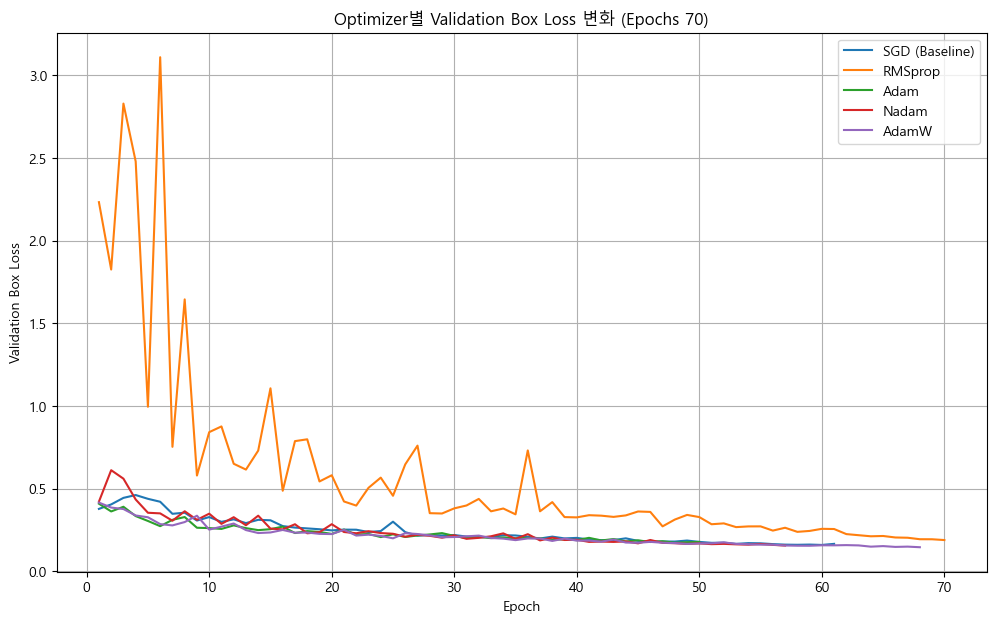

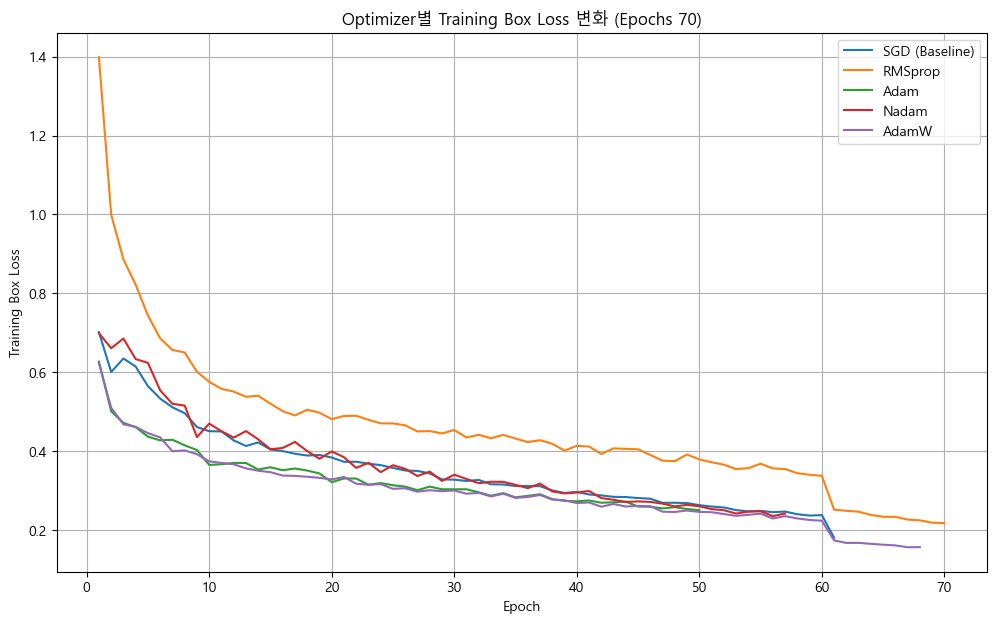

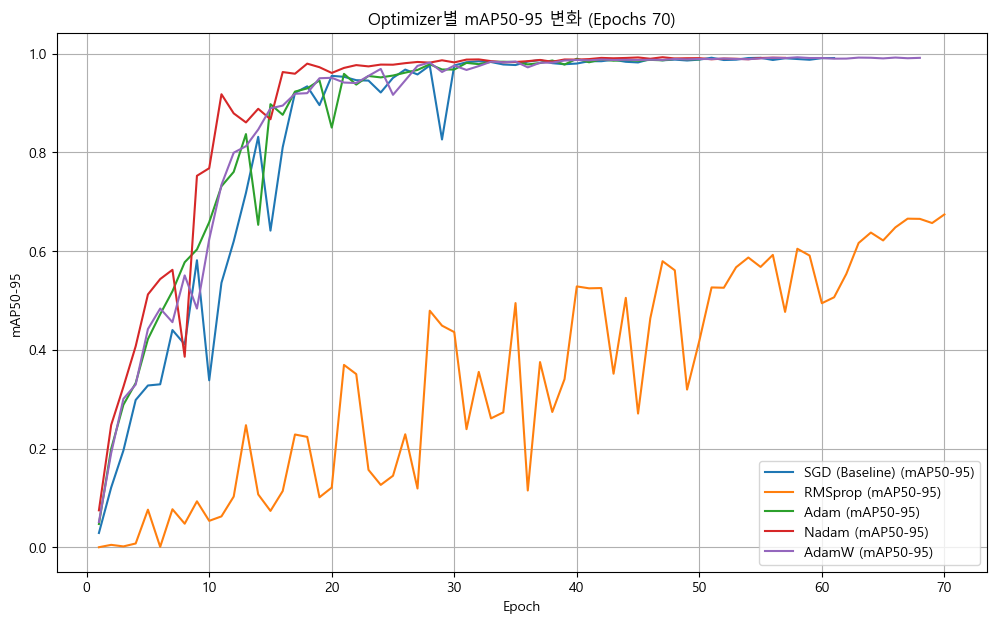

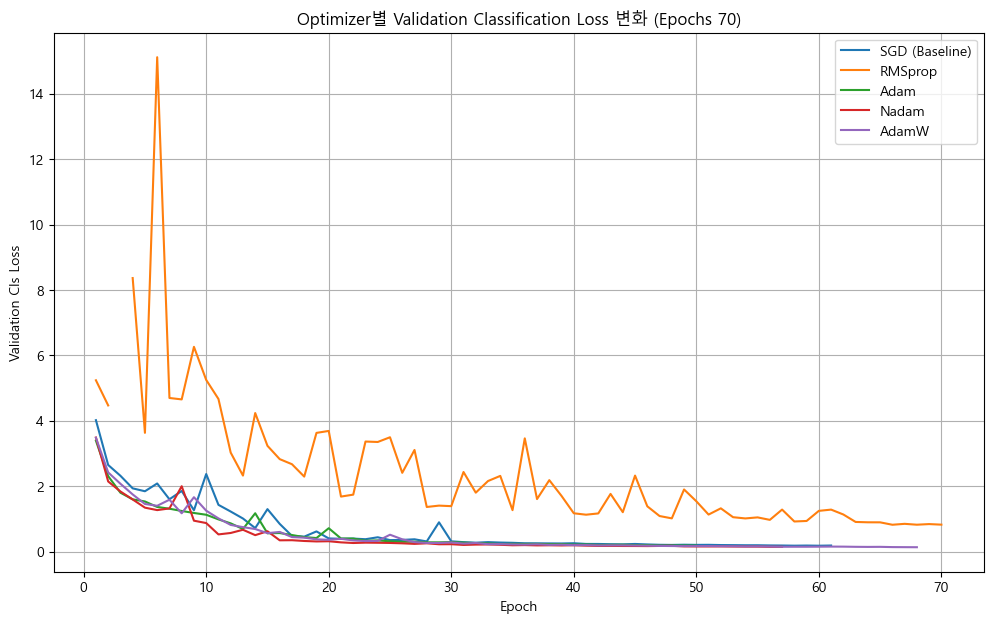

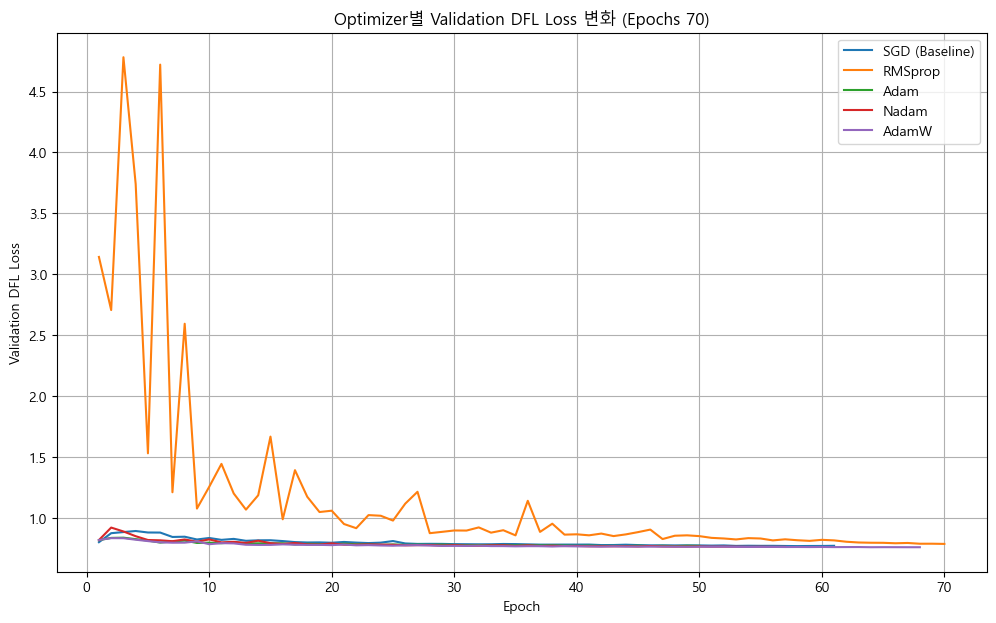

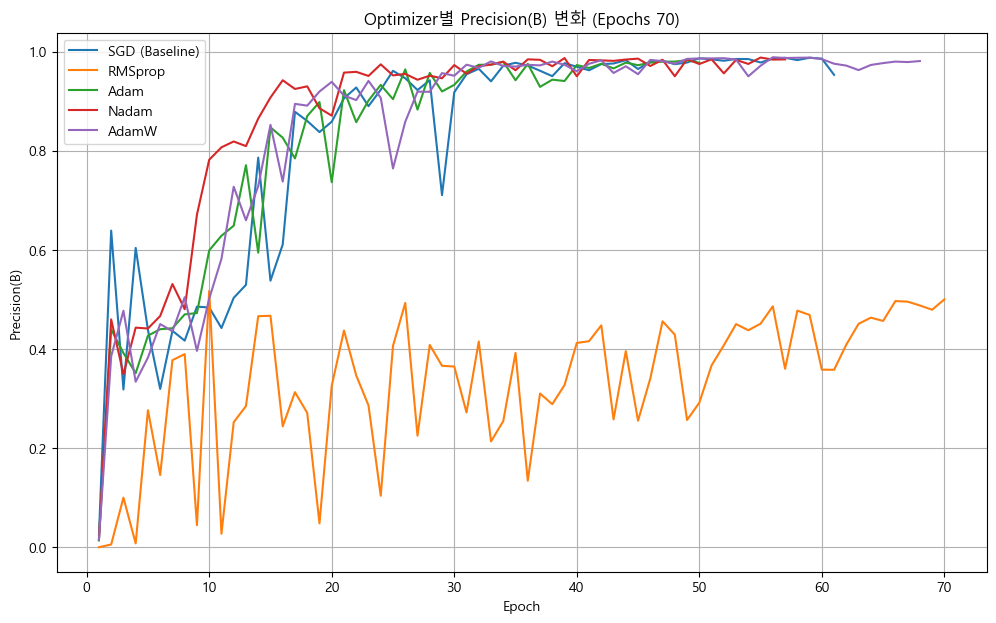

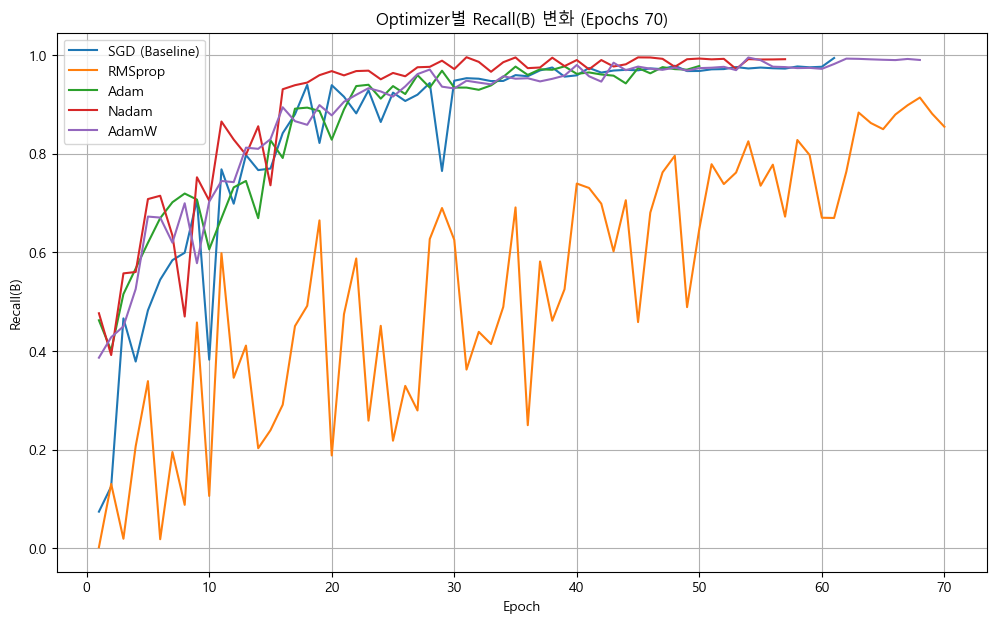

Best Epoch 및 mAP, 총 학습 시간 막대 그래프 생성 중...


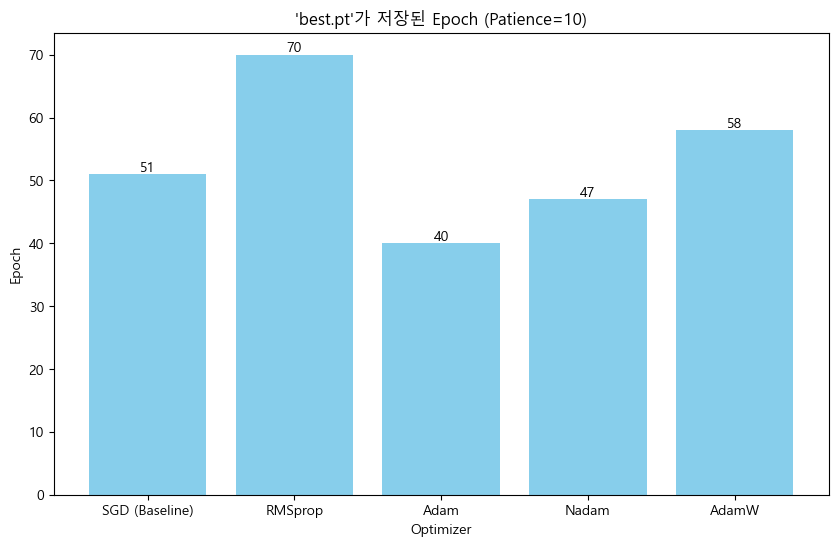

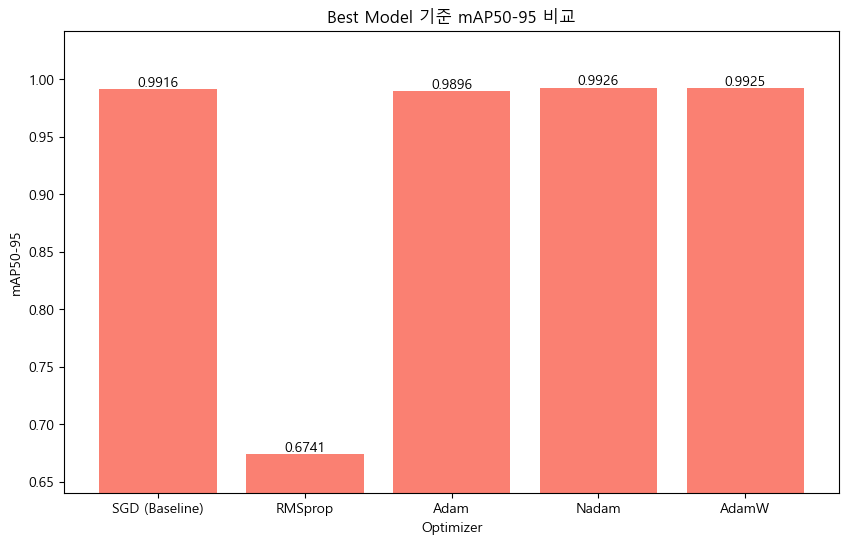

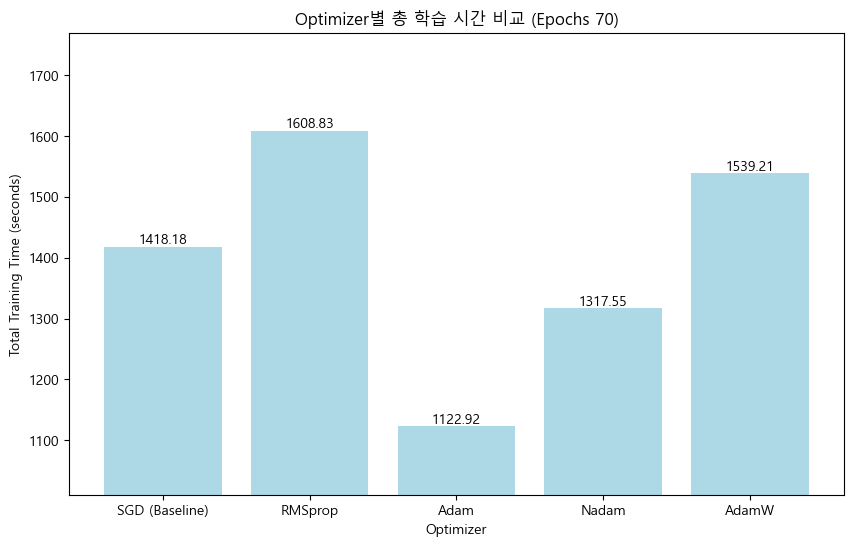

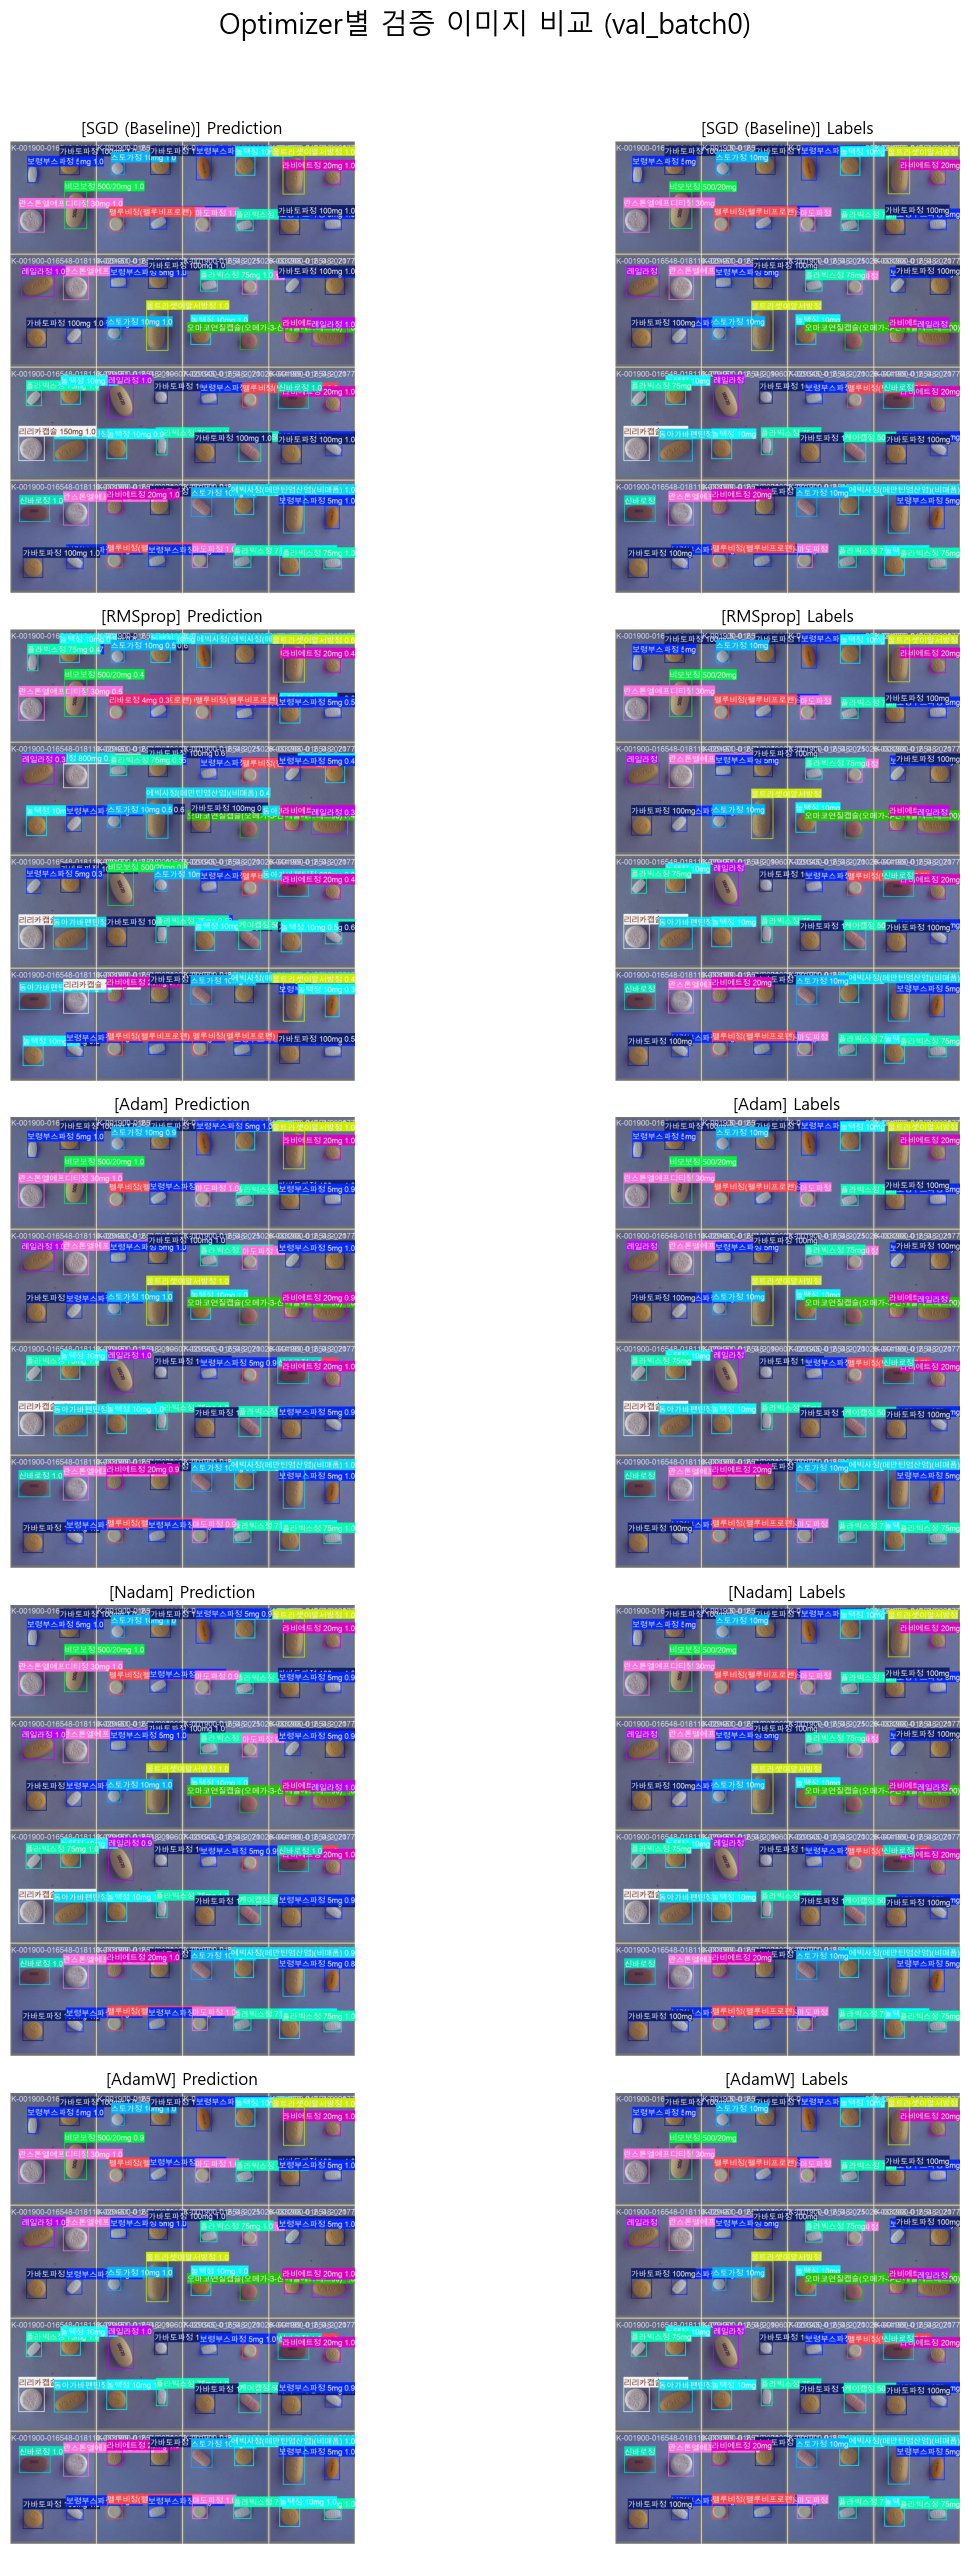


모든 분석 완료. 결과가 'C:\Users\daboi\Desktop\ai05-level1-project\Analysis_Results_Optimizers_e70' 폴더에 저장되었습니다.
생성된 파일:
- C:\Users\daboi\Desktop\ai05-level1-project\Analysis_Results_Optimizers_e70\compare_val_box_loss.png (Validation Box Loss)
- C:\Users\daboi\Desktop\ai05-level1-project\Analysis_Results_Optimizers_e70\compare_train_box_loss.png (Training Loss)
- C:\Users\daboi\Desktop\ai05-level1-project\Analysis_Results_Optimizers_e70\compare_mAP50-95.png (mAP50-95 Line)
- C:\Users\daboi\Desktop\ai05-level1-project\Analysis_Results_Optimizers_e70\compare_val_cls_loss.png (Validation Cls Loss)
- C:\Users\daboi\Desktop\ai05-level1-project\Analysis_Results_Optimizers_e70\compare_val_dfl_loss.png (Validation DFL Loss)
- C:\Users\daboi\Desktop\ai05-level1-project\Analysis_Results_Optimizers_e70\compare_precision.png (Precision)
- C:\Users\daboi\Desktop\ai05-level1-project\Analysis_Results_Optimizers_e70\compare_recall.png (Recall)
- C:\Users\daboi\Desktop\ai05-level1-project\Analysis_Results_Opt

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform
from PIL import Image
import glob
import json 

# 노트북에 그래프를 인라인으로 표시하기 위한 설정
%matplotlib inline 

# --- 폰트 설정 ---
if platform.system() == 'Windows':
    try:
        font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
    except:
        rc('font', family='DejaVu Sans')
else:  
    rc('font', family='DejaVu Sans')
plt.rcParams['axes.unicode_minus'] = False 
# --- 폰트 설정 끝 ---

# --- 경로 및 실험 설정 ---
base_dir = r"C:\Users\daboi\Desktop\ai05-level1-project"
exp_dir = os.path.join(base_dir, "Exp")
output_dir = os.path.join(base_dir, "Analysis_Results_Optimizers_e70")
os.makedirs(output_dir, exist_ok=True)

experiments = {
    "SGD (Baseline)": "yolo_n_baseline_SGD_lr01_e70",
    "RMSprop": "yolo_n_rmsprop_lr0001_aug_off_e70", 
    "Adam": "yolo_n_adam_lr0001_aug_off_e70",
    "Nadam": "yolo_n_nadam_lr0001_aug_off_e70",
    "AdamW": "yolo_n_adamw_lr0001_aug_off_e70"
}

results_data = {}
best_metrics = {}

print("결과 분석 시작...")

# --- 1. 데이터 로드 (results.csv 및 training_time.json) ---
for opt_name, exp_name in experiments.items():
    results_path = os.path.join(exp_dir, exp_name, 'results.csv')
    time_path = os.path.join(exp_dir, exp_name, 'training_time.json') 
    
    if os.path.exists(results_path):
        print(f"'{exp_name}' 결과 로드 중...")
        df = pd.read_csv(results_path, skipinitialspace=True)
        df.columns = df.columns.str.strip().str.lower()
        
        results_data[opt_name] = df
        
        primary_metric = 'metrics/map50-95(b)'
        if primary_metric not in df.columns:
            print(f"   경고: '{exp_name}'에 기본 metric '{primary_metric}'이(가) 없습니다. 이 파일을 건너뜁니다.")
            del results_data[opt_name] 
            continue 
            
        best_epoch_idx = df[primary_metric].idxmax()
        best_epoch_data = df.loc[best_epoch_idx]
        
        total_time = 0
        if os.path.exists(time_path):
            try:
                with open(time_path, 'r') as f:
                    time_data = json.load(f)
                    total_time = time_data.get('total_training_time_seconds', 0)
            except Exception as e:
                print(f"   경고: {time_path} 로드 중 오류 발생: {e}")
        else:
            print(f"   경고: {time_path}를 찾을 수 없습니다. 학습 시간을 0으로 설정합니다.")

        best_metrics[opt_name] = {
            'best_epoch': int(best_epoch_data.get('epoch', 0)), 
            'mAP50-95': best_epoch_data.get(primary_metric, 0.0),
            'mAP50': best_epoch_data.get('metrics/map50(b)', 0.0),
            'val_box_loss': best_epoch_data.get('val/box_loss', 0.0),
            # [!!] val_cls_loss 등 상세 지표 추가
            'val_cls_loss': best_epoch_data.get('val/cls_loss', 0.0),
            'val_dfl_loss': best_epoch_data.get('val/dfl_loss', 0.0),
            'train_box_loss': best_epoch_data.get('train/box_loss', 0.0), 
            'total_time': total_time 
        }
    else:
        print(f"경고: '{results_path}'를 찾을 수 없습니다. 해당 실험을 건너뜁니다.")

if not results_data:
    print("오류: 분석할 데이터를 찾을 수 없습니다. 1-5번 스크립트가 실행되었는지 확인하세요.")
    pass

if results_data: 
    print("\n--- 'best.pt' 기준 성능 요약 ---")
    for opt_name, metrics in best_metrics.items():
        print(f"[{opt_name}]")
        print(f"   - Best Epoch: {metrics['best_epoch']}")
        print(f"   - mAP50-95: {metrics['mAP50-95']:.4f}")
        print(f"   - Val Box Loss (at best epoch): {metrics['val_box_loss']:.4f}")
        # [!!] 추가된 지표 출력
        print(f"   - Val Cls Loss (at best epoch): {metrics['val_cls_loss']:.4f}")
        print(f"   - Val DFL Loss (at best epoch): {metrics['val_dfl_loss']:.4f}")
        print(f"   - Train Box Loss (at best epoch): {metrics['train_box_loss']:.4f}")
        print(f"   - Total Training Time: {metrics.get('total_time', 0):.2f}s") 
    print("="*50)

    # --- 2. Loss 및 mAP 변화 시각화 ---
    print("Loss 및 mAP 그래프 생성 중...")

    # (1) Validation Box Loss 
    plt.figure(figsize=(12, 7))
    for opt_name, df in results_data.items():
        if 'val/box_loss' in df.columns:
            plt.plot(df['epoch'], df['val/box_loss'], label=f"{opt_name}")
    plt.title("Optimizer별 Validation Box Loss 변화 (Epochs 70)")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Box Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "compare_val_box_loss.png"))
    plt.show() 
    plt.close() 

    # (2) Training Box Loss
    plt.figure(figsize=(12, 7))
    for opt_name, df in results_data.items():
        if 'train/box_loss' in df.columns:
            plt.plot(df['epoch'], df['train/box_loss'], label=f"{opt_name}")
        else:
            print(f"경고: {opt_name}의 results.csv에 'train/box_loss' 컬럼이 없습니다.")
    plt.title("Optimizer별 Training Box Loss 변화 (Epochs 70)")
    plt.xlabel("Epoch")
    plt.ylabel("Training Box Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "compare_train_box_loss.png"))
    plt.show() 
    plt.close() 


    # (3) mAP50-95 (B)
    plt.figure(figsize=(12, 7))
    for opt_name, df in results_data.items():
        if 'metrics/map50-95(b)' in df.columns:
            plt.plot(df['epoch'], df['metrics/map50-95(b)'], label=f"{opt_name} (mAP50-95)")
    plt.title("Optimizer별 mAP50-95 변화 (Epochs 70)")
    plt.xlabel("Epoch")
    plt.ylabel("mAP50-95")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "compare_mAP50-95.png"))
    plt.show() 
    plt.close() 

    # [!!!] (4) Validation Classification Loss (신규 추가) [!!!]
    plt.figure(figsize=(12, 7))
    for opt_name, df in results_data.items():
        if 'val/cls_loss' in df.columns:
            plt.plot(df['epoch'], df['val/cls_loss'], label=f"{opt_name}")
        else:
            print(f"경고: {opt_name}에 'val/cls_loss'가 없습니다.")
    plt.title("Optimizer별 Validation Classification Loss 변화 (Epochs 70)")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Cls Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "compare_val_cls_loss.png"))
    plt.show()
    plt.close()

    # [!!!] (5) Validation DFL Loss (신규 추가) [!!!]
    plt.figure(figsize=(12, 7))
    for opt_name, df in results_data.items():
        if 'val/dfl_loss' in df.columns:
            plt.plot(df['epoch'], df['val/dfl_loss'], label=f"{opt_name}")
        else:
            print(f"경고: {opt_name}에 'val/dfl_loss'가 없습니다.")
    plt.title("Optimizer별 Validation DFL Loss 변화 (Epochs 70)")
    plt.xlabel("Epoch")
    plt.ylabel("Validation DFL Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "compare_val_dfl_loss.png"))
    plt.show()
    plt.close()

    # [!!!] (6) Precision (신규 추가) [!!!]
    plt.figure(figsize=(12, 7))
    for opt_name, df in results_data.items():
        if 'metrics/precision(b)' in df.columns:
            plt.plot(df['epoch'], df['metrics/precision(b)'], label=f"{opt_name}")
        else:
            print(f"경고: {opt_name}에 'metrics/precision(b)'가 없습니다.")
    plt.title("Optimizer별 Precision(B) 변화 (Epochs 70)")
    plt.xlabel("Epoch")
    plt.ylabel("Precision(B)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "compare_precision.png"))
    plt.show()
    plt.close()

    # [!!!] (7) Recall (신규 추가) [!!!]
    plt.figure(figsize=(12, 7))
    for opt_name, df in results_data.items():
        if 'metrics/recall(b)' in df.columns:
            plt.plot(df['epoch'], df['metrics/recall(b)'], label=f"{opt_name}")
        else:
            print(f"경고: {opt_name}에 'metrics/recall(b)'가 없습니다.")
    plt.title("Optimizer별 Recall(B) 변화 (Epochs 70)")
    plt.xlabel("Epoch")
    plt.ylabel("Recall(B)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "compare_recall.png"))
    plt.show()
    plt.close()

    # --- 3. Best Epoch 및 최종 mAP 시각화 (막대 그래프) ---
    print("Best Epoch 및 mAP, 총 학습 시간 막대 그래프 생성 중...")

    opt_names = list(best_metrics.keys())
    best_epochs = [m['best_epoch'] for m in best_metrics.values()]
    final_map50_95 = [m['mAP50-95'] for m in best_metrics.values()]
    total_times = [m.get('total_time', 0) for m in best_metrics.values()] 

    # (1) Best Epoch
    plt.figure(figsize=(10, 6))
    bars = plt.bar(opt_names, best_epochs, color='skyblue')
    plt.title("'best.pt'가 저장된 Epoch (Patience=10)")
    plt.xlabel("Optimizer")
    plt.ylabel("Epoch")
    plt.bar_label(bars)
    plt.savefig(os.path.join(output_dir, "compare_best_epoch.png"))
    plt.show() 
    plt.close() 

    # (2) mAP50-95
    plt.figure(figsize=(10, 6))
    bars = plt.bar(opt_names, final_map50_95, color='salmon')
    plt.title("Best Model 기준 mAP50-95 비교")
    plt.xlabel("Optimizer")
    plt.ylabel("mAP50-95")
    if final_map50_95 and max(final_map50_95) > 0: 
        plt.ylim(min(final_map50_95) * 0.95, max(final_map50_95) * 1.05) 
    plt.bar_label(bars, fmt='%.4f')
    plt.savefig(os.path.join(output_dir, "compare_mAP50-95_bar.png")) 
    plt.show() 
    plt.close() 

    # (3) 총 학습 시간
    plt.figure(figsize=(10, 6))
    bars = plt.bar(opt_names, total_times, color='lightblue')
    plt.title("Optimizer별 총 학습 시간 비교 (Epochs 70)")
    plt.xlabel("Optimizer")
    plt.ylabel("Total Training Time (seconds)")
    if total_times and max(total_times) > 0: 
        plt.ylim(min(total_times) * 0.9, max(total_times) * 1.1)
    plt.bar_label(bars, fmt='%.2f')
    plt.savefig(os.path.join(output_dir, "compare_total_training_time.png"))
    plt.show() 
    plt.close() 


    # --- 4. 검증 이미지 샘플 비교 ---
    num_exps = len(results_data) 
    if num_exps > 0: 
        fig, axes = plt.subplots(num_exps, 2, figsize=(15, 5 * num_exps))
        fig.suptitle("Optimizer별 검증 이미지 비교 (val_batch0)", fontsize=20, y=1.02)

        if num_exps == 1: 
            axes = [axes] 

        for i, opt_name in enumerate(results_data.keys()): 
            exp_name = experiments[opt_name] 
            
            pred_img_path = os.path.join(exp_dir, exp_name, 'val_batch0_pred.jpg')
            label_img_path = os.path.join(exp_dir, exp_name, 'val_batch0_labels.jpg')

            ax_pred = axes[i][0] if num_exps > 1 else axes[0]
            if os.path.exists(pred_img_path):
                img_pred = Image.open(pred_img_path)
                ax_pred.imshow(img_pred)
                ax_pred.set_title(f"[{opt_name}] Prediction")
            else:
                ax_pred.set_title(f"[{opt_name}] Pred (Not Found)")
            ax_pred.axis('off')
            
            ax_label = axes[i][1] if num_exps > 1 else axes[1]
            if os.path.exists(label_img_path):
                img_label = Image.open(label_img_path)
                ax_label.imshow(img_label)
                ax_label.set_title(f"[{opt_name}] Labels")
            else:
                ax_label.set_title(f"[{opt_name}] Labels (Not Found)")
            ax_label.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "compare_validation_samples.png"), bbox_inches='tight')
        plt.show() 
        plt.close() 
    else:
        print("경고: 비교할 검증 이미지가 없습니다 (실험 데이터가 로드되지 않음).")


    print("\n" + "="*50)
    print(f"모든 분석 완료. 결과가 '{output_dir}' 폴더에 저장되었습니다.")
    print("생성된 파일:")
    print(f"- {os.path.join(output_dir, 'compare_val_box_loss.png')} (Validation Box Loss)")
    print(f"- {os.path.join(output_dir, 'compare_train_box_loss.png')} (Training Loss)")
    print(f"- {os.path.join(output_dir, 'compare_mAP50-95.png')} (mAP50-95 Line)")
    # [!!] 추가된 파일 목록
    print(f"- {os.path.join(output_dir, 'compare_val_cls_loss.png')} (Validation Cls Loss)")
    print(f"- {os.path.join(output_dir, 'compare_val_dfl_loss.png')} (Validation DFL Loss)")
    print(f"- {os.path.join(output_dir, 'compare_precision.png')} (Precision)")
    print(f"- {os.path.join(output_dir, 'compare_recall.png')} (Recall)")
    # ---
    print(f"- {os.path.join(output_dir, 'compare_best_epoch.png')}")
    print(f"- {os.path.join(output_dir, 'compare_mAP50-95_bar.png')} (mAP50-95 Bar)")
    print(f"- {os.path.join(output_dir, 'compare_total_training_time.png')} (총 학습 시간)")
    print(f"- {os.path.join(output_dir, 'compare_validation_samples.png')}")

# Optimizer 실험 결과 분석 및 인사이트

## 실험 결과 요약

| 옵티마이저 | Best Epoch | mAP50-95 | Val Box Loss | Val Cls Loss | Val DFL Loss | Train Box Loss | 총 시간 |
|-----------|------------|----------|--------------|--------------|--------------|---------------|---------|
| **AdamW** | 58 | **0.9925** | **0.1543** | **0.1454** | **0.7621** | 0.2295 | 1539.21s |
| **Nadam** | 47 | **0.9926** | 0.1716 | 0.1702 | 0.7661 | 0.2670 | **1317.55s** |
| SGD | 51 | 0.9916 | 0.1718 | 0.2045 | 0.7736 | 0.2596 | 1418.18s |
| Adam | 40 | 0.9896 | 0.1882 | 0.2107 | 0.7716 | 0.2728 | 1122.92s |
| RMSprop | 70 | 0.6741 | 0.1886 | 0.8212 | 0.7874 | **0.2177** | 1608.83s |

## 심층 분석

### 1. **성능 최적화 관점 (AdamW 우위)**
- **AdamW가 모든 Val Loss 항목에서 최고 성능**
  - Val Box Loss: 0.1543 (가장 낮음)
  - Val Cls Loss: 0.1454 (가장 낮음) 
  - Val DFL Loss: 0.7621 (가장 낮음)
- **특히 Cls Loss에서 큰 격차**를 보이며 분류 정확도가 뛰어남
- mAP50-95: 0.9925로 최상위 성능 유지

### 2. **효율성 관점 (Nadam 우위)**
- **가장 빠른 수렴 속도**: 1317.55초 (가장 짧은 학습 시간)
- **빠른 최적점 도달**: 47 Epoch에서 최적 성능
- mAP50-95: 0.9926으로 AdamW와 거의 동등한 정확도

### 3. **안정성 관점**
- **AdamW**: 가장 안정적인 학습 곡선 (모든 Loss 항목 균형 있게 감소)
- **Nadam**: 빠르지만 Cls Loss에서 다소 불안정
- **RMSprop**: 심각한 불안정 (Cls Loss 0.8212로 매우 높음)

### 4. **과적합 방지 관점**
- **Train Box Loss vs Val Box Loss 차이 분석**:
  - AdamW: 0.2295 vs 0.1543 (차이 0.0752)
  - Nadam: 0.2670 vs 0.1716 (차이 0.0954)
  - **AdamW가 더 나은 일반화 성능**을 보임

## 핵심

### 1. **AdamW 선택이 최선의 전략**
- **이유**: 모든 Val Loss 항목에서 최저값 + 우수한 일반화 성능
- **단점**: 학습 시간이 Nadam보다 17% 더 소요

### 2. **Nadam은 시간이 중요한 경우 대안**
- **이유**: 16% 더 빠른 학습 + 거의 동등한 mAP 성능
- **주의점**: Cls Loss가 AdamW보다 17% 높음

### 3. **RMSprop는 이 데이터셋에 부적합**
- **이유**: Cls Loss가 극도로 높아 분류 성능이 매우 낮음
- **인사이트**: 알약 분류 문제에는 RMSprop가 적합하지 않음

### 4. **실전 적용 제안**
```python
# 최고 성능을 원할 때
optimizer = "AdamW"  # 가장 안정적이고 정확함

# 빠른 실험이 필요할 때  
optimizer = "Nadam"  # 거의 동등한 성능에 더 빠름

# 피해야 할 설정
optimizer = "RMSprop"  # 분류 성능 매우 낮음